--- 1. 讀取與前處理資料 ---
  保留出現 >=10 次的商品
  有效交易筆數: 20154
--- 2. 轉換稀疏矩陣 ---
  矩陣大小: (20154, 2829)

--- 3. 執行演算法效能比較 ---
  執行 FP-Growth (Sup=0.003)...
  FP-Growth 耗時: 7.7954 秒
  執行 Apriori (Sup=0.003)...
  Apriori   耗時: 0.4247 秒
>> 圖表 1 已儲存

--- 4. 參數敏感度分析 (確保有數據) ---
  Sup=0.001, Conf=0.1 -> 規則數: 53379, 平均推薦數: 7.5, 時間: 507.4950s
  Sup=0.001, Conf=0.3 -> 規則數: 49176, 平均推薦數: 3.8, 時間: 505.8848s
  Sup=0.001, Conf=0.5 -> 規則數: 42155, 平均推薦數: 2.3, 時間: 505.2124s
  Sup=0.002, Conf=0.1 -> 規則數: 82, 平均推薦數: 1.5, 時間: 18.2907s
  Sup=0.002, Conf=0.3 -> 規則數: 47, 平均推薦數: 0.3, 時間: 18.2654s
  Sup=0.002, Conf=0.5 -> 規則數: 29, 平均推薦數: 0.2, 時間: 18.2586s
  Sup=0.003, Conf=0.1 -> 規則數: 8, 平均推薦數: 0.3, 時間: 6.3375s
  Sup=0.003, Conf=0.3 -> 規則數: 4, 平均推薦數: 0.1, 時間: 6.3337s
  Sup=0.003, Conf=0.5 -> 規則數: 1, 平均推薦數: 0.0, 時間: 6.3347s


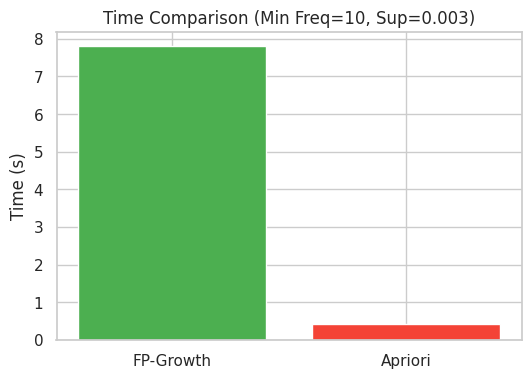

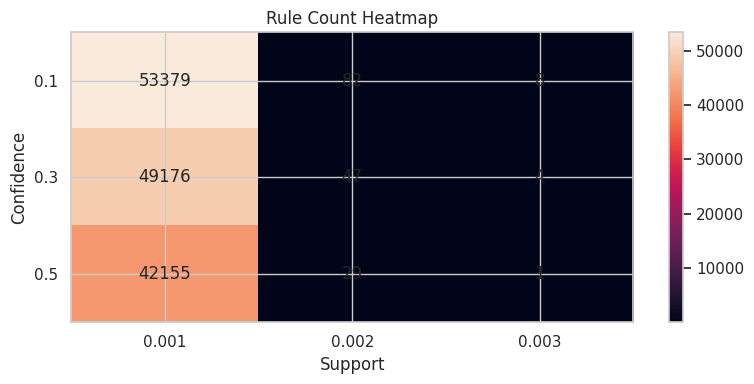

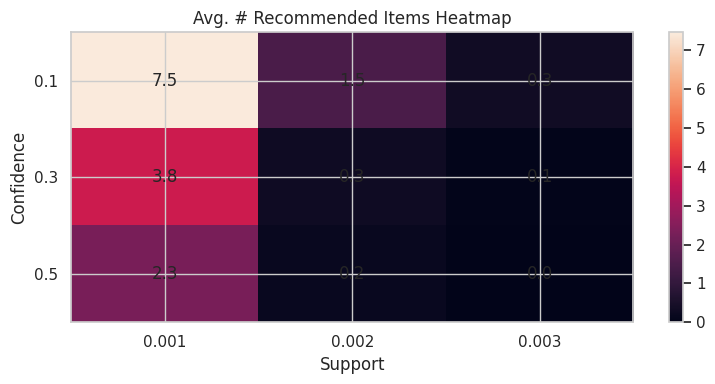

>> 圖表 2 已儲存
>> 圖表 3 已儲存

--- 5. 最終推薦展示 (A/B 版本比較模式) ---
正在建立規則庫 (Sup=0.001, Conf=0.2)...
正在將 53822 條規則存入 'all_rules.csv' ...
存檔完成！請至左側檔案區下載。
正在生成 A 版本 (作業定義) 規則庫...
正在生成 B 版本 (常理定義) 規則庫...
準備完成。A版規則數: 51484, B版規則數: 39723

請輸入產品編號 (多個產品請用逗號隔開，例如: SC7731G, SR3131)
請輸入您的購物車內容: SC7731G

您的購物車: ['SC7731G']
--------------------------------------------------
【版本 A - 作業定義】(剔除高信心短規則)
推薦清單: ['SR3131', 'SR2351C', 'SR2319A']
--------------------------------------------------
【版本 B - 常理定義】(剔除低信心長規則)
推薦清單: ['SR3131', 'SR2351C', 'SR2319A']
--------------------------------------------------
結論：兩種策略對此商品的推薦結果一致。

=== 完成 ===


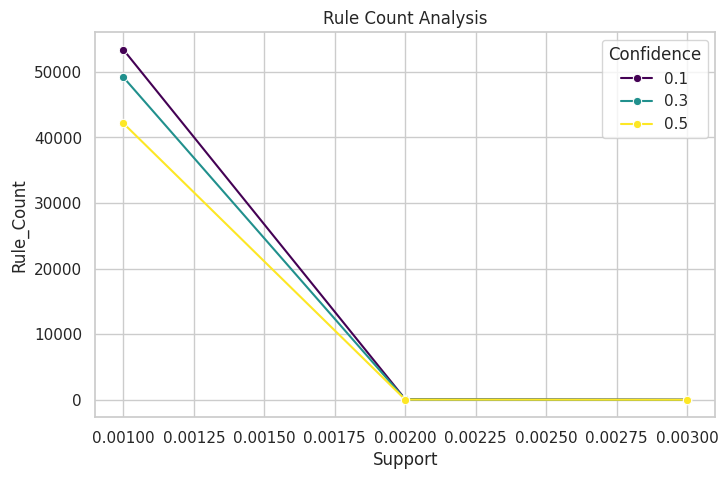

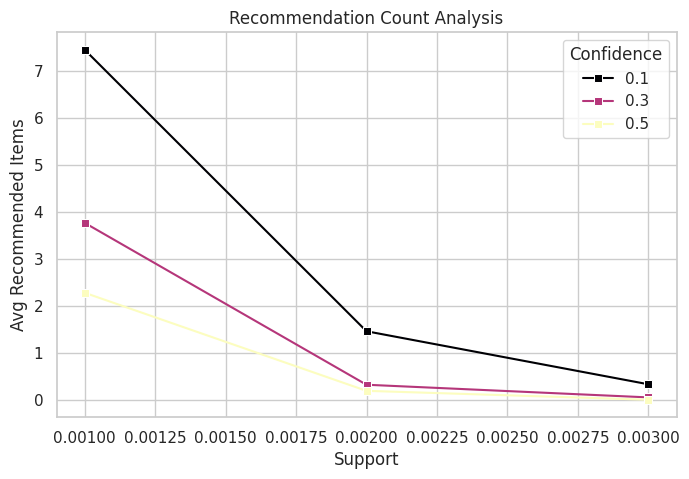

In [ ]:
# -*- coding: utf-8 -*-


import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# 1. 抑制警告訊息
warnings.filterwarnings('ignore')

# 2. 設定繪圖風格
sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']


# A. 資料讀取與前置處理
def load_and_prep(filepath, min_item_freq=10):
    print("--- 1. 讀取與前處理資料 ---")
    try:
        df = pd.read_csv(filepath)
    except:
        df = pd.read_excel(filepath)

    # 基本清洗
    df = df[df['QUANTITY'] > 0]
    df = df.dropna(subset=['INVOICE_NO', 'ITEM_NO'])
    df['ITEM_NO'] = df['ITEM_NO'].astype(str).str.strip()

    # [調整點 1] 門檻設為 10 (保留約 2000+ 商品)
    counts = df['ITEM_NO'].value_counts()
    freq_items = counts[counts >= min_item_freq].index
    df = df[df['ITEM_NO'].isin(freq_items)]

    transactions = df.groupby('INVOICE_NO')['ITEM_NO'].apply(list).tolist()
    print(f"  保留出現 >={min_item_freq} 次的商品")
    print(f"  有效交易筆數: {len(transactions)}")
    return transactions, df


# B. 核心邏輯函式
def prune_homework(rules):
    """版本 A (作業定義): 刪除高信心度短規則"""
    if rules.empty: return rules
    rules = rules.copy()
    drop_indices = set()
    for consequent, group in rules.groupby('consequents'):
        group_list = group.to_dict('records')
        indices = group.index.tolist()
        n = len(group_list)
        for i in range(n):
            for j in range(n):
                if i == j: continue
                # j(短) 是 i(長) 的子集，且 Conf(短) > Conf(長) -> 刪除短
                if group_list[j]['antecedents'] < group_list[i]['antecedents']:
                    if group_list[j]['confidence'] > group_list[i]['confidence']:
                        drop_indices.add(indices[j])
    return rules.drop(list(drop_indices))

def prune_commonsense(rules):
    """版本 B (常理定義): 刪除長規則"""
    if rules.empty: return rules
    rules = rules.copy()
    drop_indices = set()
    for consequent, group in rules.groupby('consequents'):
        group_list = group.to_dict('records')
        indices = group.index.tolist()
        n = len(group_list)
        for i in range(n):
            for j in range(n):
                if i == j: continue
                # j(短) 是 i(長) 的子集，且 Conf(短) >= Conf(長) -> 刪除長
                if group_list[j]['antecedents'] < group_list[i]['antecedents']:
                    if group_list[j]['confidence'] >= group_list[i]['confidence']:
                        drop_indices.add(indices[i])
    return rules.drop(list(drop_indices))

def recommend_count(items, rules):
    if rules.empty: return 0
    input_set = set([str(x) for x in items])
    recs = set()
    for _, row in rules.iterrows():
        if row['antecedents'].issubset(input_set):
            for item in row['consequents']:
                if item not in input_set:
                    recs.add(item)
    return len(recs)

def get_guaranteed_cart(rules):
    if rules.empty: return []
    # 找信心度最高的前件
    suitable = rules[rules['antecedents'].apply(len) <= 2]
    if suitable.empty: suitable = rules
    return list(suitable.sort_values('confidence', ascending=False).iloc[0]['antecedents'])


# 主程式
filename = '交易資料集(2).xlsx'

# 1. 載入資料 (門檻=10)
transactions, df_orig = load_and_prep(filename, min_item_freq=10)

# 2. 轉矩陣
print("--- 2. 轉換稀疏矩陣 ---")
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions, sparse=True)
df_sparse = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
print(f"  矩陣大小: {df_sparse.shape}")


# 任務一：演算法效能比較
print("\n--- 3. 執行演算法效能比較 ---")
bench_sup = 0.003

print(f"  執行 FP-Growth (Sup={bench_sup})...")
t0 = time.time()
fpgrowth(df_sparse, min_support=bench_sup, use_colnames=True)
t_fp = time.time() - t0
print(f"  FP-Growth 耗時: {t_fp:.4f} 秒")

print(f"  執行 Apriori (Sup={bench_sup})...")
t0 = time.time()
apriori(df_sparse, min_support=bench_sup, use_colnames=True)
t_ap = time.time() - t0
print(f"  Apriori   耗時: {t_ap:.4f} 秒")

plt.figure(figsize=(6, 4))
plt.bar(['FP-Growth', 'Apriori'], [t_fp, t_ap], color=['#4CAF50', '#F44336'])
plt.title(f'Time Comparison (Min Freq=10, Sup={bench_sup})')
plt.ylabel('Time (s)')
plt.savefig('1_time_comparison.png')
print(">> 圖表 1 已儲存")


# 任務二：參數分析 (重點調整區)
print("\n--- 4. 參數敏感度分析 (確保有數據) ---")
sample_carts = [list(x) for x in df_orig.sample(100)['INVOICE_NO'].apply(
    lambda inv: df_orig[df_orig['INVOICE_NO']==inv]['ITEM_NO'].tolist()
)]

# [關鍵調整] 將支持度門檻大幅調低，確保圖表有東西
supports = [0.001, 0.002, 0.003]
confidences = [0.1, 0.3, 0.5]
results = []

for s in supports:
    # 1) 先量「挖頻繁項目集」的時間（只跟 s 有關）
    t_mine0 = time.perf_counter()
    freq_sets = fpgrowth(df_sparse, min_support=s, use_colnames=True)
    t_mine = time.perf_counter() - t_mine0

    for c in confidences:
        # 2) 再量「產生規則 + 作業定義修剪」的時間（會跟 c 有關）
        t_rule0 = time.perf_counter()

        if freq_sets.empty:
            rules_pruned = pd.DataFrame()
            rule_cnt = 0
        else:
            rules = association_rules(freq_sets, metric="confidence", min_threshold=c)
            rules_pruned = prune_homework(rules)
            rule_cnt = len(rules_pruned)

        t_rule = time.perf_counter() - t_rule0

        # 3) 平均推薦數（不納入演算法時間；但你仍可照常算）
        if rule_cnt == 0:
            avg_rec = 0
        else:
            rec_counts = [recommend_count(cart, rules_pruned) for cart in sample_carts]
            avg_rec = np.mean(rec_counts) if rec_counts else 0


        # 「挖頻繁項目集 + 規則生成/修剪」
        elapsed = t_mine + t_rule

        print(f"  Sup={s}, Conf={c} -> 規則數: {rule_cnt}, 平均推薦數: {avg_rec:.1f}, 時間: {elapsed:.4f}s")
        results.append({
            'Support': s,
            'Confidence': c,
            'Rule_Count': rule_cnt,
            'Avg_Rec': avg_rec,
            'Time_sec': elapsed
        })
# 畫圖
res_df = pd.DataFrame(results)
# (1) Rule Count Heatmap
pivot_rule = res_df.pivot(index="Confidence", columns="Support", values="Rule_Count")

fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(pivot_rule.values, aspect="auto")
ax.set_title("Rule Count Heatmap")
ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_xticks(np.arange(pivot_rule.shape[1]))
ax.set_xticklabels([f"{x:.3f}" for x in pivot_rule.columns])
ax.set_yticks(np.arange(pivot_rule.shape[0]))
ax.set_yticklabels([f"{y:.1f}" for y in pivot_rule.index])

for i in range(pivot_rule.shape[0]):
    for j in range(pivot_rule.shape[1]):
        ax.text(j, i, f"{pivot_rule.values[i,j]:.0f}", ha="center", va="center")

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig("fig2_rule_counts_heatmap.png", dpi=200)
plt.show()

# (2) Avg Recommended Heatmap
pivot_rec = res_df.pivot(index="Confidence", columns="Support", values="Avg_Rec")

fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(pivot_rec.values, aspect="auto")
ax.set_title("Avg. # Recommended Items Heatmap")
ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_xticks(np.arange(pivot_rec.shape[1]))
ax.set_xticklabels([f"{x:.3f}" for x in pivot_rec.columns])
ax.set_yticks(np.arange(pivot_rec.shape[0]))
ax.set_yticklabels([f"{y:.1f}" for y in pivot_rec.index])

for i in range(pivot_rec.shape[0]):
    for j in range(pivot_rec.shape[1]):
        ax.text(j, i, f"{pivot_rec.values[i,j]:.1f}", ha="center", va="center")

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig("fig3_avg_recs_heatmap.png", dpi=200)
plt.show()

plt.figure(figsize=(8, 5))
sns.lineplot(data=res_df, x='Support', y='Rule_Count', hue='Confidence', marker='o', palette='viridis')
plt.title('Rule Count Analysis')
plt.savefig('2_rule_count_analysis.png')
print(">> 圖表 2 已儲存")

plt.figure(figsize=(8, 5))
sns.lineplot(data=res_df, x='Support', y='Avg_Rec', hue='Confidence', marker='s', palette='magma')
plt.title('Recommendation Count Analysis')
plt.ylabel('Avg Recommended Items')
plt.savefig('3_recommendation_analysis.png')
print(">> 圖表 3 已儲存")


# 任務三：最終展示 (互動模式 - A/B 版本比較)
print("\n--- 5. 最終推薦展示 (A/B 版本比較模式) ---")

# 1. 建立基礎規則庫
final_sup = 0.001
final_conf = 0.2
print(f"正在建立規則庫 (Sup={final_sup}, Conf={final_conf})...")

# 重新執行 FP-Growth
freq_sets = fpgrowth(df_sparse, min_support=final_sup, use_colnames=True)
rules_raw = association_rules(freq_sets, metric="confidence", min_threshold=final_conf)

if not rules_raw.empty:
    # 【修正點】這裡補回存檔指令
    print(f"正在將 {len(rules_raw)} 條規則存入 'all_rules.csv' ...")
    rules_raw.to_csv('all_rules.csv', index=False)
    print("存檔完成！請至左側檔案區下載。")

    # 分別準備兩種規則庫
    print("正在生成 A 版本 (作業定義) 規則庫...")
    rules_A = prune_homework(rules_raw)

    print("正在生成 B 版本 (常理定義) 規則庫...")
    rules_B = prune_commonsense(rules_raw)

    print(f"準備完成。A版規則數: {len(rules_A)}, B版規則數: {len(rules_B)}")

    # === 手動輸入 ===
    print("\n請輸入產品編號 (多個產品請用逗號隔開，例如: SC7731G, SR3131)")
    user_input = input("請輸入您的購物車內容: ")

    # 處理輸入
    test_cart = [x.strip() for x in user_input.split(',') if x.strip()]

    if not test_cart:
        print("警告: 您沒有輸入任何商品。")
    else:
        print(f"\n您的購物車: {test_cart}")
        input_set = set(test_cart)

        # --- 定義推薦函式 ---
        def get_recommendations(cart_set, rules, name):
            recs = []
            found_rule = False
            for _, row in rules.iterrows():
                if row['antecedents'].issubset(cart_set):
                    found_rule = True
                    for item in row['consequents']:
                        if item not in cart_set and item not in recs:
                            recs.append(item)
            return recs, found_rule

        # --- 取得 A 版結果 ---
        recs_A, found_A = get_recommendations(input_set, rules_A, "作業定義")

        # --- 取得 B 版結果 ---
        recs_B, found_B = get_recommendations(input_set, rules_B, "常理定義")

        # --- 展示比較結果 ---
        print("-" * 50)
        print(f"【版本 A - 作業定義】(剔除高信心短規則)")
        if recs_A:
            print(f"推薦清單: {recs_A[:10]}")
        else:
            status = "規則庫有對應但無新商品" if found_A else "查無相關規則"
            print(f"無推薦結果 ({status})")

        print("-" * 50)
        print(f"【版本 B - 常理定義】(剔除低信心長規則)")
        if recs_B:
            print(f"推薦清單: {recs_B[:10]}")
        else:
            status = "規則庫有對應但無新商品" if found_B else "查無相關規則"
            print(f"無推薦結果 ({status})")
        print("-" * 50)

        # 簡單結論
        if recs_A == recs_B and recs_A:
            print("結論：兩種策略對此商品的推薦結果一致。")
        elif recs_A != recs_B:
            print("結論：兩種策略產生了不同的推薦結果，請記錄差異。")

else:
    print("錯誤: 規則庫為空，請檢查支持度門檻設定。")

print("\n=== 完成 ===")

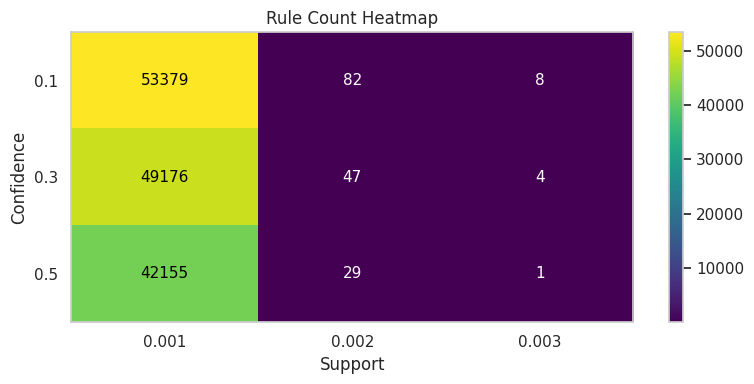

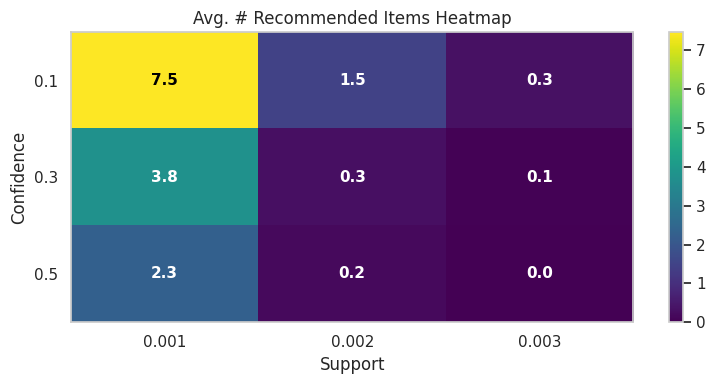

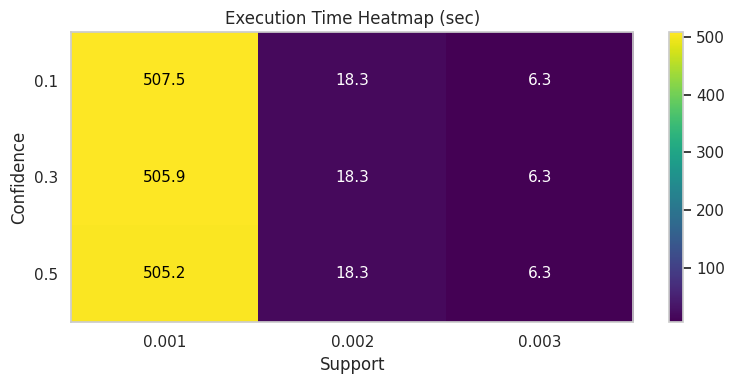

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# 設定統一配色
# ==========================================
UNIFIED_CMAP = "viridis"


# 無格線版
pivot_rule = res_df.pivot(index="Confidence", columns="Support", values="Rule_Count")

fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(pivot_rule.values, aspect="auto", cmap=UNIFIED_CMAP)

# 關閉網格線
ax.grid(False)

ax.set_title("Rule Count Heatmap")
ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_xticks(np.arange(pivot_rule.shape[1]))
ax.set_xticklabels([f"{x:.3f}" for x in pivot_rule.columns])
ax.set_yticks(np.arange(pivot_rule.shape[0]))
ax.set_yticklabels([f"{y:.1f}" for y in pivot_rule.index])

# 文字自動變色
norm = im.norm
for i in range(pivot_rule.shape[0]):
    for j in range(pivot_rule.shape[1]):
        val = pivot_rule.values[i, j]
        rgba = im.cmap(norm(val))
        luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        text_color = "black" if luminance > 0.5 else "white"
        ax.text(j, i, f"{val:.0f}", ha="center", va="center",
                color=text_color, fontsize=11)

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig("fig2_rule_counts_heatmap.png", dpi=200)
plt.show()



#無格線版
pivot_rec = res_df.pivot(index="Confidence", columns="Support", values="Avg_Rec")

fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(pivot_rec.values, aspect="auto", cmap=UNIFIED_CMAP)

#關閉網格線
ax.grid(False)

ax.set_title("Avg. # Recommended Items Heatmap")
ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_xticks(np.arange(pivot_rec.shape[1]))
ax.set_xticklabels([f"{x:.3f}" for x in pivot_rec.columns])
ax.set_yticks(np.arange(pivot_rec.shape[0]))
ax.set_yticklabels([f"{y:.1f}" for y in pivot_rec.index])

norm = im.norm
for i in range(pivot_rec.shape[0]):
    for j in range(pivot_rec.shape[1]):
        val = pivot_rec.values[i, j]
        rgba = im.cmap(norm(val))
        luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        text_color = "black" if luminance > 0.5 else "white"
        ax.text(j, i, f"{val:.1f}", ha="center", va="center",
                color=text_color, fontsize=11, fontweight="bold")

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig("fig3_avg_recs_heatmap.png", dpi=200)
plt.show()



#(無格線版)

pivot_time = res_df.pivot(index="Confidence", columns="Support", values="Time_sec")

fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(pivot_time.values, aspect="auto", cmap=UNIFIED_CMAP)


ax.grid(False)

ax.set_title("Execution Time Heatmap (sec)")
ax.set_xlabel("Support")
ax.set_ylabel("Confidence")
ax.set_xticks(np.arange(pivot_time.shape[1]))
ax.set_xticklabels([f"{x:.3f}" for x in pivot_time.columns])
ax.set_yticks(np.arange(pivot_time.shape[0]))
ax.set_yticklabels([f"{y:.1f}" for y in pivot_time.index])

norm = im.norm
for i in range(pivot_time.shape[0]):
    for j in range(pivot_time.shape[1]):
        val = pivot_time.values[i, j]
        rgba = im.cmap(norm(val))
        luminance = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        text_color = "black" if luminance > 0.5 else "white"
        ax.text(j, i, f"{val:.1f}", ha="center", va="center",
                color=text_color, fontsize=11)

fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig("fig4_time_heatmap.png", dpi=200)
plt.show()

In [ ]:
# 先確認 rules_raw 真的還在
print("rules_raw rows:", len(rules_raw))

# 存成 CSV
rules_raw.to_csv("all_rules.csv", index=False, encoding="utf-8-sig")
print("已輸出 all_rules.csv")


rules_raw rows: 53822
已輸出 all_rules.csv


In [ ]:
# -*- coding: utf-8 -*-
"""
獨立推薦測試模組
功能：讀取已生成的規則 CSV 檔，進行推薦測試 (無需重新訓練模型)。
需求：請確認左側檔案區已上傳 'all_rules.csv'。
"""

import pandas as pd
import numpy as np


# 1. 定義必要的函式

def prune_homework(rules):
    """版本 A (作業定義): 刪除高信心度短規則"""
    if rules.empty: return rules
    rules = rules.copy()
    # 建立索引列表以便快速存取
    rules_list = rules.to_dict('records')
    # 為了效能，這邊使用比較簡單的邏輯：
    # 若 CSV 很大，建議直接用原始邏輯，但這裡我們需確保索引對齊
    # 這裡沿用原本的邏輯
    drop_indices = set()

    # 依後件分群加速
    for consequent, group in rules.groupby('consequents'):
        group_list = group.to_dict('records')
        indices = group.index.tolist()
        n = len(group_list)
        for i in range(n):
            for j in range(n):
                if i == j: continue
                # j(短) 是 i(長) 的子集 (邏輯檢查)
                if group_list[j]['antecedents'] < group_list[i]['antecedents']:
                    # 且 Conf(短) > Conf(長) -> 刪除短(j)
                    if group_list[j]['confidence'] > group_list[i]['confidence']:
                        drop_indices.add(indices[j])
    return rules.drop(list(drop_indices))

def prune_commonsense(rules):
    """版本 B (常理定義): 刪除長規則"""
    if rules.empty: return rules
    rules = rules.copy()
    drop_indices = set()
    for consequent, group in rules.groupby('consequents'):
        group_list = group.to_dict('records')
        indices = group.index.tolist()
        n = len(group_list)
        for i in range(n):
            for j in range(n):
                if i == j: continue
                # j(短) 是 i(長) 的子集
                if group_list[j]['antecedents'] < group_list[i]['antecedents']:
                    # 且 Conf(短) >= Conf(長) -> 刪除長(i)
                    if group_list[j]['confidence'] >= group_list[i]['confidence']:
                        drop_indices.add(indices[i])
    return rules.drop(list(drop_indices))

def get_recommendations(cart_set, rules):
    recs = []
    found_rule = False
    for _, row in rules.iterrows():
        # 檢查規則的前件是否包含在購物車中
        if row['antecedents'].issubset(cart_set):
            found_rule = True
            for item in row['consequents']:
                if item not in cart_set and item not in recs:
                    recs.append(item)
    return recs, found_rule


# 2. 載入與還原 CSV 資料
filename = 'all_rules.csv'

try:
    print(f"正在讀取 {filename} ...")
    rules_raw = pd.read_csv(filename)

    # 【關鍵步驟】將 CSV 中的字串 "frozenset({'A'})" 還原回 Python 物件
    # 這樣 issubset 等集合運算才能正常運作
    print("正在還原資料格式 (字串 -> 集合)...")
    rules_raw['antecedents'] = rules_raw['antecedents'].apply(lambda x: eval(x))
    rules_raw['consequents'] = rules_raw['consequents'].apply(lambda x: eval(x))

    print(f"讀取成功！共載入 {len(rules_raw)} 條規則。")


    # 3. 建立 A/B 版本規則庫
    print("正在生成 A 版本 (作業定義) 規則庫...")
    rules_A = prune_homework(rules_raw)

    print("正在生成 B 版本 (常理定義) 規則庫...")
    rules_B = prune_commonsense(rules_raw)

    print(f"準備完成。A版規則數: {len(rules_A)}, B版規則數: {len(rules_B)}")


    # 4. 互動式輸入迴圈
    while True:
        print("\n" + "="*50)
        print("請輸入產品編號 (輸入 'exit' 或 'q' 離開)")
        print("範例輸入: SC7731G, SR3131")
        user_input = input("請輸入您的購物車內容: ")

        if user_input.lower() in ['exit', 'q', 'quit']:
            print("程式結束。")
            break

        # 處理輸入
        test_cart = [x.strip() for x in user_input.split(',') if x.strip()]

        if not test_cart:
            print("警告: 您沒有輸入任何商品。")
            continue

        print(f"\n您的購物車: {test_cart}")
        input_set = set(test_cart)

        # --- 取得 A 版結果 ---
        recs_A, found_A = get_recommendations(input_set, rules_A)

        # --- 取得 B 版結果 ---
        recs_B, found_B = get_recommendations(input_set, rules_B)

        # --- 展示比較結果 ---
        print("-" * 50)
        print(f"【版本 A - 作業定義】(剔除高信心短規則)")
        if recs_A:
            print(f"推薦清單: {recs_A[:10]}")
        else:
            status = "規則庫有對應但無新商品" if found_A else "查無相關規則"
            print(f"無推薦結果 ({status})")

        print("-" * 50)
        print(f"【版本 B - 常理定義】(剔除低信心長規則)")
        if recs_B:
            print(f"推薦清單: {recs_B[:10]}")
        else:
            status = "規則庫有對應但無新商品" if found_B else "查無相關規則"
            print(f"無推薦結果 ({status})")
        print("-" * 50)

        # 簡單結論
        if recs_A == recs_B and recs_A:
            print("結論：兩種策略對此商品的推薦結果一致。")
        elif recs_A != recs_B:
            print("結論：兩種策略產生了不同的推薦結果。")

except FileNotFoundError:
    print(f"錯誤：找不到檔案 '{filename}'。請確認您已將 CSV 檔上傳至 Colab 左側檔案區。")
except Exception as e:
    print(f"發生錯誤：{e}")

正在讀取 all_rules.csv ...
正在還原資料格式 (字串 -> 集合)...
讀取成功！共載入 53822 條規則。
正在生成 A 版本 (作業定義) 規則庫...
正在生成 B 版本 (常理定義) 規則庫...
準備完成。A版規則數: 51484, B版規則數: 39723

請輸入產品編號 (輸入 'exit' 或 'q' 離開)
範例輸入: SC7731G, SR3131
請輸入您的購物車內容: SC7731G

您的購物車: ['SC7731G']
--------------------------------------------------
【版本 A - 作業定義】(剔除高信心短規則)
推薦清單: ['SR3131', 'SR2351C', 'SR2319A']
--------------------------------------------------
【版本 B - 常理定義】(剔除低信心長規則)
推薦清單: ['SR3131', 'SR2351C', 'SR2319A']
--------------------------------------------------
結論：兩種策略對此商品的推薦結果一致。

請輸入產品編號 (輸入 'exit' 或 'q' 離開)
範例輸入: SC7731G, SR3131


KeyboardInterrupt: Interrupted by user